<a href="https://colab.research.google.com/github/JasonDepblu/potential-spork/blob/balaced_data/Copy_of_content_based_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%
import time
import pandas as pd
import numpy as np
import random
import mpl_toolkits.axisartist as ast
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
import tensorflow as tf
from keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import copy

In [2]:
# load the data
dsc_up_df = pd.read_csv(
    r'/content/dsc_up.csv')
car_dict_df = pd.read_csv(
    r'/content/car_dict2.csv')

dsc_up_df = dsc_up_df.replace({np.NaN: 0})
car_dict_df = car_dict_df.replace({np.NaN: 0})

dsc_up = dsc_up_df.values
car_dict = car_dict_df.values

print(dsc_up.shape)
print(car_dict.shape)

(13653, 33)
(119, 83)


In [3]:
num_cars = len(car_dict)
print(num_cars)

119


In [4]:
# balance samples
dsc_up_bal = np.empty(shape=(1, dsc_up.shape[1]))

for i in range(num_cars):
  if len(dsc_up[dsc_up[:, 31] == i]) > 500:
    ran_row_bal = np.random.choice(np.arange(len(dsc_up[dsc_up[:, 31] == i])), size=500, replace=False)
    dsc_up_bali = dsc_up[dsc_up[:, 31] == i][ran_row_bal]
  else:
    dsc_up_bali = dsc_up[dsc_up[:, 31] == i]
  dsc_up_bal = np.concatenate((dsc_up_bal, dsc_up_bali), axis=0)
dsc_up = dsc_up_bal[1:]
print(dsc_up.shape)

(10292, 33)


In [5]:
# load the label
print(car_dict.shape)
print(dsc_up.shape)

ys_up = dsc_up[:, 31]
print(ys_up)

(119, 83)
(10292, 33)
[0 0 0 ... 118 118 118]


In [6]:
# transfer the label to onehot_code
ys = copy.copy(ys_up.reshape(len(ys_up), 1))
ys -= 1
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(ys)
ys = onehot_encoded
print(ys.shape)

(10292, 119)


In [7]:
# column of last feature from 0 and +1
col_last_feature_car = 80
    #76
col_last_feature_user = 28
car_unscaled = car_dict[:, 1:col_last_feature_car]
user_unscaled = dsc_up[:, 1:col_last_feature_user]

# generate the gaussian random no. to budget feature
mu_budget = 0
sigma_budget = 2.5
for i in range(len(user_unscaled)):
    user_unscaled[i, 23] += random.gauss(mu_budget, sigma_budget)

scalerCar = StandardScaler()
scalerCar.fit(car_dict[:, 1:col_last_feature_car])
car = scalerCar.transform(car_dict[:, 1:col_last_feature_car])

scalerUser = StandardScaler()
scalerUser.fit(dsc_up[:, 1:col_last_feature_user])
user = scalerUser.transform(dsc_up[:, 1:col_last_feature_user])

print(np.allclose(car_unscaled.astype(float), scalerCar.inverse_transform(car)))
print(np.allclose(user_unscaled.astype(float), scalerUser.inverse_transform(user)))

True
True


In [8]:
# func for generating num_items users of different cars
def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict matrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (1, num_items))
    return user_vecs

def gen_car_vecs(car_vec, num_users):
    car_vecs = np.tile(car_vec, (num_users, 1))
    return car_vecs

In [9]:
# pca analysis
pca_25 = PCA(n_components=25)
print(pca_25)
pca_25.fit(user)
print(pca_25.explained_variance_ratio_)

# %%
pca_30 = PCA(n_components=2)
print(pca_30)
pca_30.fit(car_dict[:, 1:15])
print(pca_30.explained_variance_ratio_)
c_trans = pca_30.transform(car_dict[:, 1:15])
# plt.plot(c_trans[:, 0], c_trans[:, 1], 'ro')


PCA(n_components=25)
[0.07814742 0.06376633 0.05658644 0.0512597  0.04890179 0.04240121
 0.04004364 0.03903929 0.03843698 0.03761012 0.0372187  0.03627247
 0.03568546 0.0350127  0.03470774 0.03388448 0.03333184 0.03298696
 0.03252683 0.03177072 0.03011896 0.02988924 0.02852947 0.0259103
 0.02553896]
PCA(n_components=2)
[0.79305611 0.14624711]


In [10]:
# generate num_items users for different cars
user_vecs = gen_user_vecs(user, len(car_dict))
user_vecs = user_vecs.reshape(-1, user.shape[1])
car_vecs = gen_car_vecs(car, len(dsc_up))

ys = ys.reshape(-1, 1)
print(user_vecs.shape)
print(car_vecs.shape)
print(ys.shape)

(1224748, 27)
(1224748, 79)
(1224748, 1)


In [11]:
ys[ys == 0].shape

(1214456,)

In [12]:
# # case 2
# car_train, car_test = train_test_split(car_vecs, train_size=0.8, shuffle=True, random_state=2023)
# user_train, user_test = train_test_split(user_vecs, train_size=0.8, shuffle=True, random_state=2023)
# ys_train, ys_test = train_test_split(ys, train_size=0.8, shuffle=True, random_state=2023)

# car_val, car_test = train_test_split(car_test, train_size=0.5, shuffle=True, random_state=2023)
# user_val, user_test = train_test_split(user_test, train_size=0.5, shuffle=True, random_state=2023)
# ys_val, ys_test = train_test_split(ys_test, train_size=0.5, shuffle=True, random_state=2023)

In [13]:
randnum = random.randint(0, 100)
print(randnum)
random.seed(randnum)

32


In [14]:
# # case 2
# user_train_one = user_train[(ys_train == 1)[:, 0]]
# user_train_one = gen_car_vecs(user_train_one, np.ceil(len(car_dict) * 0.3 -1).astype(int))
# user_train_zero = user_train[(ys_train == 0)[:, 0]]
# user_train = np.concatenate((user_train_zero, user_train_one), axis=0)
# random.seed(randnum)
# random.shuffle(user_train)
# print(user_train.shape)

In [15]:
# # case 2
# car_train_one = car_train[(ys_train == 1)[:, 0]]
# car_train_one = gen_car_vecs(car_train_one, np.ceil(len(car_dict) * 0.3 -1).astype(int))
# car_train_zero = car_train[(ys_train == 0)[:, 0]]
# car_train = np.concatenate((car_train_zero, car_train_one), axis=0)
# random.seed(randnum)
# random.shuffle(car_train)
# print(car_train.shape)

In [16]:
# # case 2
# ys_one = ys_train[(ys_train == 1)[:, 0]]
# ys_one = gen_car_vecs(ys_one, np.ceil(len(car_dict) * 0.3 -1).astype(int))
# ys_zero = ys_train[(ys_train == 0)[:, 0]]
# ys_train = np.concatenate((ys_zero, ys_one), axis=0)
# random.seed(randnum)
# random.shuffle(ys_train)
# print(ys_train.shape)

In [17]:
# user_vecs_one = user_vecs[(ys == 1)[:, 0]]

In [18]:
# num_users = user_vecs_one.shape[0]
# print(num_users)


In [19]:
# user_vecs_zero = user_vecs[(ys == 0)[:, 0]]
# num_zeros = user_vecs_zero.shape[0]
# print(num_zeros)

In [20]:
# random.seed(randnum)

In [21]:
# sample_row = np.random.choice(np.arange(num_zeros), size=num_users, replace=False)

In [22]:
# sample_row

In [23]:
# user_vecs_zero = user_vecs_zero[sample_row]
# print(user_vecs_zero.shape)

In [24]:
# case 3
user_vecs_one = user_vecs[(ys == 1)[:, 0]]
# user_vecs_one = gen_car_vecs(user_vecs_one, len(car_dict)-1)
user_vecs_zero = user_vecs[(ys == 0)[:, 0]]
num_users = user_vecs_one.shape[0]
num_zeros = user_vecs_zero.shape[0]
random.seed(randnum)

sample_row = np.random.choice(np.arange(num_zeros), size=np.ceil(num_users * 1.3).astype(int), replace=False)
user_vecs_zero = user_vecs_zero[sample_row]
user_vecs = np.concatenate((user_vecs_zero, user_vecs_one), axis=0)

random.seed(44)
shuffle_row = np.random.choice(np.arange(0,len(user_vecs)), len(user_vecs), replace=False)
user_vecs = user_vecs[shuffle_row]
print(user_vecs.shape)

(23672, 27)


In [25]:
# case3
car_vecs_one = car_vecs[(ys == 1)[:, 0]]
# car_vecs_one = gen_car_vecs(car_vecs_one, len(car_dict)-1)

car_vecs_zero = car_vecs[(ys == 0)[:, 0]][sample_row]
car_vecs = np.concatenate((car_vecs_zero, car_vecs_one), axis=0)

car_vecs = car_vecs[shuffle_row]
print(car_vecs.shape)

(23672, 79)


In [26]:
# case 3
ys_one = ys[(ys == 1)[:, 0]]
# ys_one = gen_car_vecs(ys_one, len(car_dict)-1)

ys_zero = ys[(ys == 0)[:, 0]][sample_row]
ys = np.concatenate((ys_zero, ys_one), axis=0)

ys = ys[shuffle_row]
print(ys.shape)

(23672, 1)


In [27]:
print(ys[0:50])

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]


In [28]:
# case 3
car_train, car_test = train_test_split(car_vecs, train_size=0.8, shuffle=True, random_state=2023)
user_train, user_test = train_test_split(user_vecs, train_size=0.8, shuffle=True, random_state=2023)
ys_train, ys_test = train_test_split(ys, train_size=0.8, shuffle=True, random_state=2023)

car_val, car_test = train_test_split(car_test, train_size=0.5, shuffle=True, random_state=2023)
user_val, user_test = train_test_split(user_test, train_size=0.5, shuffle=True, random_state=2023)
ys_val, ys_test = train_test_split(ys_test, train_size=0.5, shuffle=True, random_state=2023)

In [29]:
print(f"cars training data shape:{car_train.shape}")
print(f"cars validating data shape:{car_val.shape}")
print(f"cars testing data shape:{car_test.shape}")

print(f"users training data shape:{user_train.shape}")
print(f"users validating data shape:{user_val.shape}")
print(f"users testing data shape:{user_test.shape}")

print(f"ys training data shape:{ys_train.shape}")
print(f"ys validating data shape:{ys_val.shape}")
print(f"ys testing data shape:{ys_test.shape}")

cars training data shape:(18937, 79)
cars validating data shape:(2367, 79)
cars testing data shape:(2368, 79)
users training data shape:(18937, 27)
users validating data shape:(2367, 27)
users testing data shape:(2368, 27)
ys training data shape:(18937, 1)
ys validating data shape:(2367, 1)
ys testing data shape:(2368, 1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 27)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 79)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           44192       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32)           57504       ['input_2[0][0]']                
                                                                                              

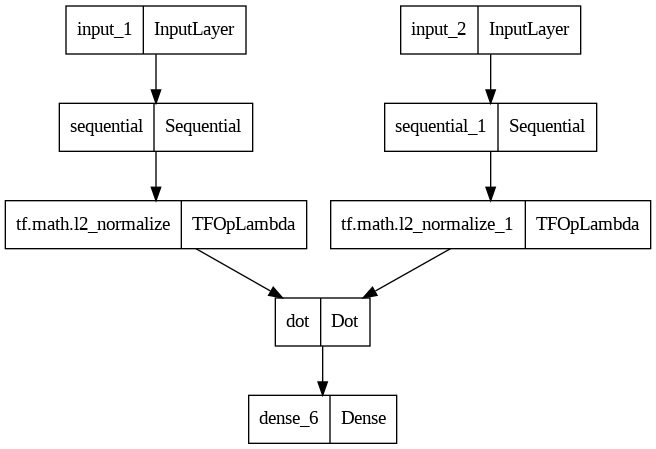

In [30]:
num_user_features = col_last_feature_user-1
num_car_features = col_last_feature_car-1
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='relu'),
])
car_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='relu'),
])

input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

input_car = tf.keras.layers.Input(shape=(num_car_features))
vc = car_NN(input_car)
vc = tf.linalg.l2_normalize(vc, axis=1)

d_out = tf.keras.layers.Dot(axes=1)([vu, vc])
output = tf.keras.layers.Dense(1, activation='sigmoid')(d_out)

model = tf.keras.Model([input_user, input_car], output)
model.summary()
tf.keras.utils.plot_model(model, "/content/my_model.png")

In [31]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=cost_fn)

In [32]:
tf.random.set_seed(1)
model.fit([user_train, car_train], ys_train, epochs=8)

Epoch 1/8
592/592 [==============================] - 7s 8ms/step - loss: 0.1883
Epoch 2/8
592/592 [==============================] - 4s 6ms/step - loss: 0.1601
Epoch 3/8
592/592 [==============================] - 5s 8ms/step - loss: 0.1344
Epoch 4/8
592/592 [==============================] - 5s 9ms/step - loss: 0.1215
Epoch 5/8
592/592 [==============================] - 4s 7ms/step - loss: 0.1171
Epoch 6/8
592/592 [==============================] - 4s 7ms/step - loss: 0.1152
Epoch 7/8
592/592 [==============================] - 4s 6ms/step - loss: 0.1136
Epoch 8/8
592/592 [==============================] - 3s 6ms/step - loss: 0.1116


In [33]:
model.evaluate([user_val, car_val], ys_val)

74/74 [==============================] - 1s 6ms/step - loss: 0.1124


0.11238411068916321

In [34]:
ys_test.shape

(2368, 1)

In [35]:
model.evaluate([user_test[(ys_test == 0)[:, 0]], car_test[(ys_test == 0)[:, 0]]], ys_test[(ys_test == 0)[:, 0]])

43/43 [==============================] - 0s 3ms/step - loss: 0.1123


0.11230051517486572

In [36]:
model.evaluate([user_test[(ys_test == 1)[:, 0]], car_test[(ys_test == 1)[:, 0]]], ys_test[(ys_test == 1)[:, 0]])

32/32 [==============================] - 0s 3ms/step - loss: 0.1199


0.11991053074598312

In [37]:
ys_p_test = model.predict([[user_test, car_test]])
ys_p_test_vs = np.concatenate((ys_p_test, ys_test), axis=1)
ys_test_df = pd.DataFrame(ys_p_test_vs)
ys_test_df.to_csv(r'/content/ys_p_test_6epoch.csv', encoding='UTF-8')

74/74 [==============================] - 0s 1ms/step


In [38]:
# print the confusion matrix & report
print(confusion_matrix(ys_test, np.round(ys_p_test)))
print(classification_report(ys_test, np.round(ys_p_test)))

[[1137  221]
 [ 136  874]]
              precision    recall  f1-score   support

         0.0       0.89      0.84      0.86      1358
         1.0       0.80      0.87      0.83      1010

    accuracy                           0.85      2368
   macro avg       0.85      0.85      0.85      2368
weighted avg       0.85      0.85      0.85      2368



In [39]:
ys_test[ys_test==0].shape

(1358,)

In [40]:
ys_p_train = model.predict([[user_train, car_train]])

592/592 [==============================] - 1s 2ms/step


In [41]:
# print the confusion matrix & report
print(confusion_matrix(ys_train, np.round(ys_p_train)))
print(classification_report(ys_train, np.round(ys_p_train)))

[[9093 1633]
 [ 972 7239]]
              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87     10726
         1.0       0.82      0.88      0.85      8211

    accuracy                           0.86     18937
   macro avg       0.86      0.86      0.86     18937
weighted avg       0.87      0.86      0.86     18937



基于某个用户，预测不同的车的购买倾向

In [43]:
list = []
for i in range(len(dsc_up)):
  if dsc_up[i, 31] == 56:
    list.append(i)
print(list)

[5447, 5448, 5449, 5450, 5451, 5452, 5453, 5454, 5455, 5456, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465, 5466, 5467, 5468, 5469, 5470, 5471, 5472, 5473, 5474, 5475, 5476, 5477, 5478, 5479, 5480, 5481, 5482, 5483, 5484, 5485, 5486, 5487, 5488, 5489, 5490, 5491, 5492, 5493, 5494, 5495, 5496, 5497, 5498, 5499, 5500, 5501, 5502]


In [53]:
# predict the new car of new performance for specific user
# define the cars and the user
row_car_dict = np.arange(0, num_cars) 
row_user_dst = [5447]
new_car = car_unscaled[row_car_dict]
new_user = gen_car_vecs(user_unscaled[row_user_dst], len(row_car_dict))

# predict the new car of new performance
new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])
print(f'target car is {dsc_up[row_user_dst, 32]}, car No. is {dsc_up[row_user_dst, 31]}')
for i in range(len(row_car_dict)):
    print(
        f'{i} :'
        f'{car_dict[row_car_dict, 81].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

4/4 [==============================] - 0s 4ms/step
target car is ['影酷 2022款 1.5T DCT基本型'], car No. is [56]
0 :['影酷 2022款 1.5T 超新星PRO版'] : [0.389] : [0.]
1 :['影酷 2022款 2.0T 中子星PRO版'] : [0.153] : [0.]
2 :['影酷 2022款 2.0T 中子星MAX版'] : [0.066] : [0.]
3 :['影酷 2022款 2.0ATK 双子星PRO版'] : [0.065] : [0.]
4 :['影酷 2022款 2.0ATK 双子星MAX版'] : [0.03] : [0.]
5 :['Model Y 2022款 改款 后轮驱动版'] : [0.006] : [0.]
6 :['Model Y 2022款 改款 长续航全轮驱动版'] : [0.026] : [0.]
7 :['Model Y 2022款 Performance高性能全轮驱动版'] : [0.023] : [0.]
8 :['AION V 2023款 Plus 70 智领版 三元锂'] : [0.015] : [0.]
9 :['AION V 2023款 Plus 70 行政版 三元锂'] : [0.012] : [0.]
10 :['AION V 2023款 Plus 70 七座商务版'] : [0.016] : [0.]
11 :['AION V 2023款 Plus 70 智享科技版 磷酸铁锂'] : [0.011] : [0.]
12 :['AION V 2023款 Plus 70 智享科技版 三元锂'] : [0.011] : [0.]
13 :['AION V 2023款 Plus 70 智享七座版 三元锂'] : [0.015] : [0.]
14 :['AION V 2023款 Plus 70 超级快充版 三元锂'] : [0.011] : [0.]
15 :['AION V 2023款 Plus 80 智领版 三元锂'] : [0.012] : [0.]
16 :['AION V 2023款 Plus 80 智享科技版 三元锂'] : [0.008] : [0.]
17 :['AION V

In [54]:
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.5] = 1
new_y_true = np.zeros((new_y_predict.shape))
new_y_true[row_car_dict == dsc_up[row_user_dst, 31]] = 1

print(confusion_matrix(new_y_true, new_y_predict))
print(classification_report(new_y_true, new_y_predict))


[[85 33]
 [ 0  1]]
              precision    recall  f1-score   support

         0.0       1.00      0.72      0.84       118
         1.0       0.03      1.00      0.06         1

    accuracy                           0.72       119
   macro avg       0.51      0.86      0.45       119
weighted avg       0.99      0.72      0.83       119



In [46]:
dsc_up[row_user_dst, 31]

array([32], dtype=object)

In [47]:
new_y_predict_vs = np.concatenate((new_y_predict, new_y_true), axis=1)
new_y_predict_vs = np.concatenate((new_car_predict, new_y_predict_vs), axis=1)
new_y_predict_df = pd.DataFrame(new_y_predict_vs)
new_y_predict_df.to_csv(r'/content/new_car_predict_vs.csv', encoding='UTF-8')

基于某款车预测不同用户的购买倾向

In [74]:
row_car_dict = [56]
row_user_dst = np.arange(0, num_users)
new_car = gen_car_vecs(car_unscaled[row_car_dict], len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 81]}, car No. is {car_dict[row_car_dict, 82]}')
for i in range(min(len(row_user_dst), 200)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 32].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

322/322 [==============================] - 0s 1ms/step
target car is ['影酷 2022款 1.5T DCT基本型'], car No. is [56]
User0 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.856] : [1.]
User1 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.819] : [1.]
User2 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.856] : [1.]
User3 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.78] : [1.]
User4 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.856] : [1.]
User5 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.823] : [1.]
User6 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.781] : [1.]
User7 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.81] : [1.]
User8 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.843] : [1.]
User9 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.818] : [1.]
User10 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.856] : [1.]
User11 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.856] : [1.]
User12 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.845] : [1.]
User

In [75]:
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.5] = 1
new_y_true = np.zeros((new_y_predict.shape))
new_y_true[dsc_up[row_user_dst, 31] == row_car_dict] = 1

print(confusion_matrix(new_y_true, new_y_predict))
print(classification_report(new_y_true, new_y_predict))

[[8887 1349]
 [  17   39]]
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93     10236
         1.0       0.03      0.70      0.05        56

    accuracy                           0.87     10292
   macro avg       0.51      0.78      0.49     10292
weighted avg       0.99      0.87      0.92     10292



In [78]:
new_y_predict_vs = np.concatenate((new_y_predict, new_y_true), axis=1)
new_y_predict_vs = np.concatenate((new_car_predict, new_y_predict_vs), axis=1)
new_y_predict_vs = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_y_predict_vs), axis=1)
new_y_predict_df = pd.DataFrame(new_y_predict_vs)
new_y_predict_df.to_csv(r'/content/new_user_predict_vs2.csv', encoding='UTF-8')

**others：**

In [51]:
new_car_predict = np.concatenate((new_car_predict, dsc_up[0:, 30].reshape(-1, 1)), axis=1)
new_car_predict_df = pd.DataFrame(new_car_predict)
new_car_predict_df.to_csv(r'/content/new_car_predict3.csv', encoding='UTF-8')

In [52]:
a = np.array([0,1,2])
b = np.array([1,2,3])
print(np.dot(a,b))

8
